# GLM analysis on the main tasks
It uses nilearn and performs the following steps:
1. Load the data from fmriPrep in BIDS format
2. Iterate on the subjects to:
   1. Select the predictors and confounds for the design matrix
   2. Generate 1st level model
   3. Estimate contrast maps
3. Generate group level maps
4. Generate hMT+ mask

In [1]:
# Imports
import os
import glob
from nilearn.glm.first_level import first_level_from_bids
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.interfaces.bids import save_glm_to_bids
from nilearn.glm import threshold_stats_img
from nilearn import plotting
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nilearn.glm.second_level import SecondLevelModel
from nilearn.reporting import get_clusters_table
from nilearn.image import math_img
from nilearn.masking import apply_mask
from src import mnitools # AAL labelling

In [2]:
# Settings
data_dir = '/DATAPOOL/BRAINPLAYBACK/BIDS-BRAINPLAYBACK-TASK1/'
space_label = "MNI152NLin2009cAsym"
derivatives_folder = "derivatives/fmriprep/fmriprep"
task_label = "01"
smoothing_fwhm = 4.0
high_pass_hz = 0.007
out_dir = os.path.join(data_dir,"derivatives","nilearn_glm")

In [17]:
# sub-set of subject to process (sub-20 events still not ready)
sub_labels = ['12','09']
# sub_labels = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19']

## 1. Load the data from fmriPrep in BIDS format

In [18]:
# import first level data automatically from fmriPrep derivatives
(
    models,
    models_run_imgs,
    models_events,
    models_confounds,
) = first_level_from_bids(
    data_dir,
    task_label,
    space_label,
    sub_labels = sub_labels,
    hrf_model="spm",
    noise_model="ar2",
    smoothing_fwhm=smoothing_fwhm,
    high_pass=high_pass_hz,
    slice_time_ref=None,
    n_jobs=12,
    minimize_memory = False,
    derivatives_folder=derivatives_folder,
)

In [5]:
models_events[0][0]

,onset,duration,trial_type
0,0.00,11.95,Baseline
1,11.95,12.01,Noise
2,23.96,12.04,Baseline
3,36.00,11.50,Q4_p
4,36.00,11.50,Q4_db
...,...,...,...
67,540.04,11.50,Q3_db
68,552.03,11.51,Q3_p
69,552.03,11.51,Q3_db
70,564.03,11.51,Q1_p


In [19]:
# edit all models_events to exclude the conditions that end with '_db' - use the participant report (p) and not the database one (db)
for ii in range(len(models_events)):
    for jj in range(len(models_events[ii])):
        models_events[ii][jj] = models_events[ii][jj][models_events[ii][jj].trial_type.str.endswith('_db') == False]

models_events[0][2]

,onset,duration,trial_type
0,0.00,11.95,Baseline
1,11.95,12.02,Noise
2,23.97,12.04,Baseline
3,36.00,11.53,Q3_p
5,47.97,11.51,Q2_p
7,59.99,11.50,Q2_p
9,71.96,12.00,Baseline
10,83.96,12.01,Noise
11,95.96,12.04,Baseline
12,108.00,11.51,Q4_p


In [20]:
# check for the existence of all of the four conditions (Q1_p, Q2_p, Q3_p, Q4_p) in all models_events
n_of_altered_runs = 0

for ii in range(len(models_events)):
    for jj in range(len(models_events[ii])):

        trial_types = models_events[ii][jj].trial_type

        # select only the ones that end with '_p'
        trial_types = trial_types[trial_types.str.endswith('_p')]

        # find unique values
        trial_types = trial_types.unique()

        # check if all four conditions are present
        if len(trial_types) != 4:

            # add the missing condition as new row with onset 0, duration 0
            if 'Q1_p' not in trial_types:
                models_events[ii][jj] = models_events[ii][jj].append({'onset': 0, 'duration': 999, 'trial_type': 'Q1_p'}, ignore_index=True)
            if 'Q2_p' not in trial_types:
                models_events[ii][jj] = models_events[ii][jj].append({'onset': 0, 'duration': 999, 'trial_type': 'Q2_p'}, ignore_index=True)  
            if 'Q3_p' not in trial_types:
                models_events[ii][jj] = models_events[ii][jj].append({'onset': 0, 'duration': 999, 'trial_type': 'Q3_p'}, ignore_index=True)
            if 'Q4_p' not in trial_types:
                models_events[ii][jj] = models_events[ii][jj].append({'onset': 0, 'duration': 999, 'trial_type': 'Q4_p'}, ignore_index=True)

            n_of_altered_runs += 1

print('Number of altered runs: ', n_of_altered_runs)


Number of altered runs:  0


# 2. Deal with contrast names
These should be balanced here.

In [3]:
# condition names
condition_names = ['Q1_p','Q2_p','Q3_p','Q4_p']

# create strings for contrasts in the format of "condition_name - Noise"
contrasts = []

# add contrast all conditions vs. noise
contrasts.append("Q1_p + Q2_p + Q3_p + Q4_p - Noise*4")

# iterate to add the other contrasts
for condition in condition_names:
    contrasts.append(condition + " - Noise")

# add more contrasts based on the arousal and valence
contrasts.append("Q1_p*0.5 + Q2_p*0.5 - Q3_p*0.5 - Q4_p*0.5") # positive arousal vs. negative arousal
contrasts.append("Q1_p*0.5 + Q4_p*0.5 - Q3_p*0.5 - Q2_p*0.5") # positive valence vs. negative valence

# just for fun - each Q against the other
contrasts.append("Q1_p - Q2_p")
contrasts.append("Q1_p - Q3_p")
contrasts.append("Q1_p - Q4_p")
contrasts.append("Q2_p - Q3_p")
contrasts.append("Q2_p - Q4_p")
contrasts.append("Q3_p - Q4_p")

contrasts

['Q1_p + Q2_p + Q3_p + Q4_p - Noise*4',
 'Q1_p - Noise',
 'Q2_p - Noise',
 'Q3_p - Noise',
 'Q4_p - Noise',
 'Q1_p*0.5 + Q2_p*0.5 - Q3_p*0.5 - Q4_p*0.5',
 'Q1_p*0.5 + Q4_p*0.5 - Q3_p*0.5 - Q2_p*0.5',
 'Q1_p - Q2_p',
 'Q1_p - Q3_p',
 'Q1_p - Q4_p',
 'Q2_p - Q3_p',
 'Q2_p - Q4_p',
 'Q3_p - Q4_p']

In [4]:
# This is to use the contrasts as names for the output files
contrasts_renamed = ['Q1234MinusNoise',
                     'Q1MinusNoise',
                     'Q2MinusNoise',
                     'Q3MinusNoise',
                     'Q4MinusNoise',
                     'PositiveArousalMinusNegativeArousal',
                     'PositiveValenceMinusNegativeValence',
                     'Q1MinusQ2',
                     'Q1MinusQ3',
                     'Q1MinusQ4',
                     'Q2MinusQ3',
                     'Q2MinusQ4',
                     'Q3MinusQ4']

contrasts_renamed

['Q1234MinusNoise',
 'Q1MinusNoise',
 'Q2MinusNoise',
 'Q3MinusNoise',
 'Q4MinusNoise',
 'PositiveArousalMinusNegativeArousal',
 'PositiveValenceMinusNegativeValence',
 'Q1MinusQ2',
 'Q1MinusQ3',
 'Q1MinusQ4',
 'Q2MinusQ3',
 'Q2MinusQ4',
 'Q3MinusQ4']

# 3. Iterate on the subjects
This takes a while, as it estimates the multi-run GLM for each subject.

In [23]:
n_scans = 600  # number of scans
tr = 1  # repetition time is 1 second
frame_times = np.arange(n_scans) * tr  # here are the corresponding frame times

for idx in range(len(models)):

    # fetch model
    model, imgs, events, confounds = (
        models[idx],
        models_run_imgs[idx],
        models_events[idx],
        models_confounds[idx],
    )

    subject = f"sub-{model.subject_label}"

    print(f"Computing 1st level model for subject: {subject}")

    # trim confounds and replace NaNs with 0
    for ii in range(len(confounds)):
        confounds[ii] = confounds[ii][['trans_x', 'trans_x_derivative1', 'trans_x_power2', 'trans_x_derivative1_power2',
                                        'trans_y', 'trans_y_derivative1', 'trans_y_power2', 'trans_y_derivative1_power2',
                                        'trans_z', 'trans_z_derivative1', 'trans_z_power2', 'trans_z_derivative1_power2',
                                        'rot_x', 'rot_x_derivative1', 'rot_x_power2', 'rot_x_derivative1_power2',
                                        'rot_y', 'rot_y_derivative1', 'rot_y_power2', 'rot_y_derivative1_power2',
                                        'rot_z', 'rot_z_derivative1', 'rot_z_power2', 'rot_z_derivative1_power2',
                                            ]]
    
        confounds[ii] = confounds[ii].fillna(0)
    
    # create design matrices
    X_list = []
    for ii in range(len(events)):
        X = make_first_level_design_matrix(
            frame_times,
            events[ii],
            add_regs=confounds[ii],
        )

        # find the condition name that should be zeroed
        if events[ii].iloc[-1].duration == 999:
            # fetch name
            cond_name = events[ii].iloc[-1].trial_type
            # zero the condition
            X[cond_name] = 0
        
        X_list.append(X)

    # Fit and contrasts
    model.fit(imgs,design_matrices=X_list)

    # create and save z_map, t_map, and beta_map to nifti files for every contrast
    for ii in range(len(contrasts)):

        z_map = model.compute_contrast(contrasts[ii], output_type="z_score")
        t_map = model.compute_contrast(contrasts[ii], output_type="stat")
        beta_map = model.compute_contrast(contrasts[ii], output_type="effect_size")

        z_map.to_filename(os.path.join(out_dir, f"{subject}_task-{task_label}_stat-z_con-{contrasts_renamed[ii]}.nii.gz"))
        t_map.to_filename(os.path.join(out_dir, f"{subject}_task-{task_label}_stat-t_con-{contrasts_renamed[ii]}.nii.gz"))
        beta_map.to_filename(os.path.join(out_dir, f"{subject}_task-{task_label}_stat-beta_con-{contrasts_renamed[ii]}.nii.gz"))

    # Attempt to free memory
    del model, imgs, events, confounds
    

Computing 1st level model for subject: sub-12


/DATAPOOL/home/alexandresayal/anaconda3/envs/brainplayback/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 4 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")
/DATAPOOL/home/alexandresayal/anaconda3/envs/brainplayback/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 4 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")
/DATAPOOL/home/alexandresayal/anaconda3/envs/brainplayback/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 4 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")
/DATAPOOL/home/alexandresayal/anaconda3/envs/brainplayback/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 4 runs
  warn(f"One contrast give

Computing 1st level model for subject: sub-09


/DATAPOOL/home/alexandresayal/anaconda3/envs/brainplayback/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 4 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")
/DATAPOOL/home/alexandresayal/anaconda3/envs/brainplayback/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 4 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")
/DATAPOOL/home/alexandresayal/anaconda3/envs/brainplayback/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 4 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")
/DATAPOOL/home/alexandresayal/anaconda3/envs/brainplayback/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 4 runs
  warn(f"One contrast give

# 4. Group level analysis

In [5]:
# just some paths again
out_dir = os.path.join(data_dir,"derivatives","nilearn_glm")
out_dir_group = os.path.join(data_dir,"derivatives","nilearn_glm","group")
if not os.path.exists(out_dir_group):
    os.makedirs(out_dir_group)

In [6]:
# choose a contrast
c_idx = 0

# List all tmap nii.gz files
tmap_files = glob.glob(
    os.path.join(out_dir,
        f"sub-*_task-{task_label}_stat-t_con-{contrasts_renamed[c_idx]}.nii.gz"
    )
)
tmap_files.sort()

# List all zmap nii.gz files
zmap_files = glob.glob(
    os.path.join(out_dir,
        f"sub-*_task-{task_label}_stat-z_con-{contrasts_renamed[c_idx]}.nii.gz"
    )
)
zmap_files.sort()

subject_list = [os.path.basename(f).split('_')[0] for f in tmap_files]
subject_list

['sub-01',
 'sub-02',
 'sub-03',
 'sub-04',
 'sub-05',
 'sub-06',
 'sub-07',
 'sub-08',
 'sub-09',
 'sub-10',
 'sub-11',
 'sub-12',
 'sub-13',
 'sub-14',
 'sub-15',
 'sub-16',
 'sub-17',
 'sub-18',
 'sub-19']

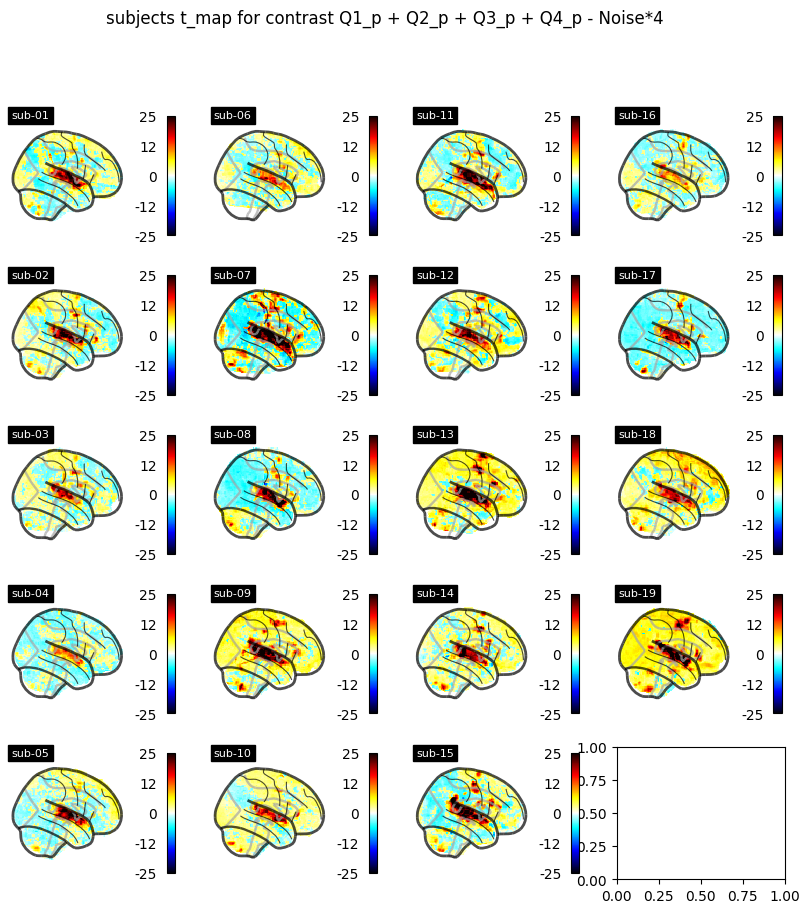

In [26]:
#| label: plot_glass_matrix_singlesubject

# Plot all subjects t_maps for a given contrast
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 10))

for cidx, tmap in enumerate(tmap_files):
    P = plotting.plot_glass_brain(
        tmap,
        colorbar=True,
        threshold=0,
        vmax=25,
        axes=axes[cidx % 5, int(cidx / 5)],
        plot_abs=False,
        display_mode="x",
    )
    P.title(subject_list[cidx], size=8)

fig.suptitle(f"subjects t_map for contrast {contrasts[c_idx]}")
plt.show()

In [7]:
# create design matrix for 2nd level
second_level_input = zmap_files
design_matrix_g = pd.DataFrame(
    [1] * len(second_level_input),
    columns=["intercept"],
)

# define 2nd level model
second_level_model = SecondLevelModel(smoothing_fwhm=6.0, n_jobs=12)
second_level_model.minimize_memory = False
second_level_model = second_level_model.fit(
    second_level_input,
    design_matrix=design_matrix_g,
)

# compute contrast (z score map)
z_map_g = second_level_model.compute_contrast(
    second_level_contrast="intercept",
    output_type="z_score",
)

# compute contrast (t score map)
t_map_g = second_level_model.compute_contrast(
    second_level_contrast="intercept",
    output_type="stat",
)

# compute contrast (beta map)
beta_map_g = second_level_model.compute_contrast(
    second_level_contrast="intercept",
    output_type='effect_size',
)

In [9]:
# Threshold zmap and plot it
hc = 'fdr' # None, 'bonferroni', 'fdr'
ct = 25 # cluster threshold
alpha = 0.005 # p-value threshold

clean_map_g, threshold_g = threshold_stats_img(
    z_map_g, alpha=alpha, height_control=hc, cluster_threshold=ct
)

In [ ]:
# glass brain
plotting.plot_glass_brain(
    clean_map_g,
    colorbar=True,
    threshold=threshold_g,
    plot_abs=False,
    display_mode="ortho",
    #vmax=8,
    figure=plt.figure(figsize=(10, 4)),
    symmetric_cbar=False,
    #cmap=nilearn_cmaps["cold_hot"],
)

plt.savefig(os.path.join(out_dir_group,
                         f"group_task-{task_label}_plot-z_con-_{contrasts_renamed[c_idx]}_c-{hc}_p-{alpha}_clusterk-{ct}.png"))

In [21]:
# Export cluster table
table_g,cluster_map_g = get_clusters_table(z_map_g, threshold_g, ct,
                                return_label_maps=True)

# AAL labelling
table_g['AAL'] = 'NA'

# Iterate over rows in table
for index, row in table_g.iterrows():
    # add AAL structure to dataframe
    _, tab_ = mnitools.find_structure([row['X'], row['Y'], row['Z']])
    aal_s = tab_[-1][-1]
    table_g.loc[index, 'AAL'] = aal_s

table_g.to_csv(os.path.join(out_dir_group,
                          f"group_task-{task_label}_table-clusters_con-{contrasts_renamed[c_idx]}_c-{hc}_p-{alpha}_clusterk-{ct}.tsv"),sep='\t')

table_g

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),AAL
0,1,57.5,-4.5,1.5,7.291228,34968,Temporal_Sup_R (aal)
1,1a,49.5,-14.5,3.5,7.051939,,Heschl_R (aal)
2,1b,65.5,-28.5,7.5,6.893036,,Temporal_Sup_R (aal)
3,1c,43.5,-24.5,5.5,6.823291,,Temporal_Sup_R (aal)
4,2,-58.5,-10.5,3.5,7.005290,34376,Temporal_Sup_L (aal)
5,2a,-48.5,-16.5,1.5,6.954840,,Temporal_Sup_L (aal)
6,2b,-44.5,-22.5,7.5,6.749131,,Temporal_Sup_L (aal)
7,2c,-50.5,-0.5,-2.5,6.428437,,Temporal_Sup_L (aal)
8,3,15.5,-24.5,-4.5,5.838663,952,Thal_MGN_R (aal)
9,4,-14.5,-26.5,-6.5,5.501539,816,undefined


/DATAPOOL/home/alexandresayal/anaconda3/envs/brainplayback/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



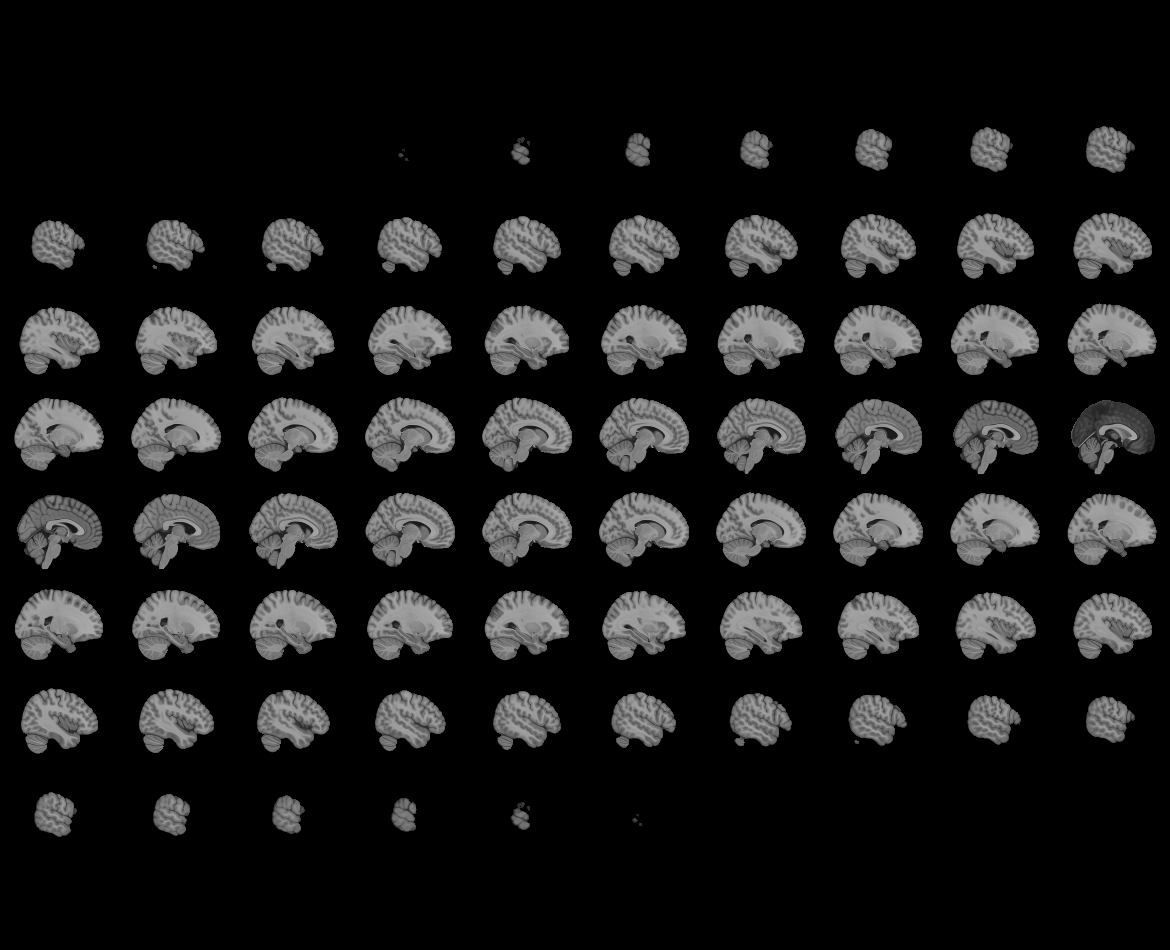
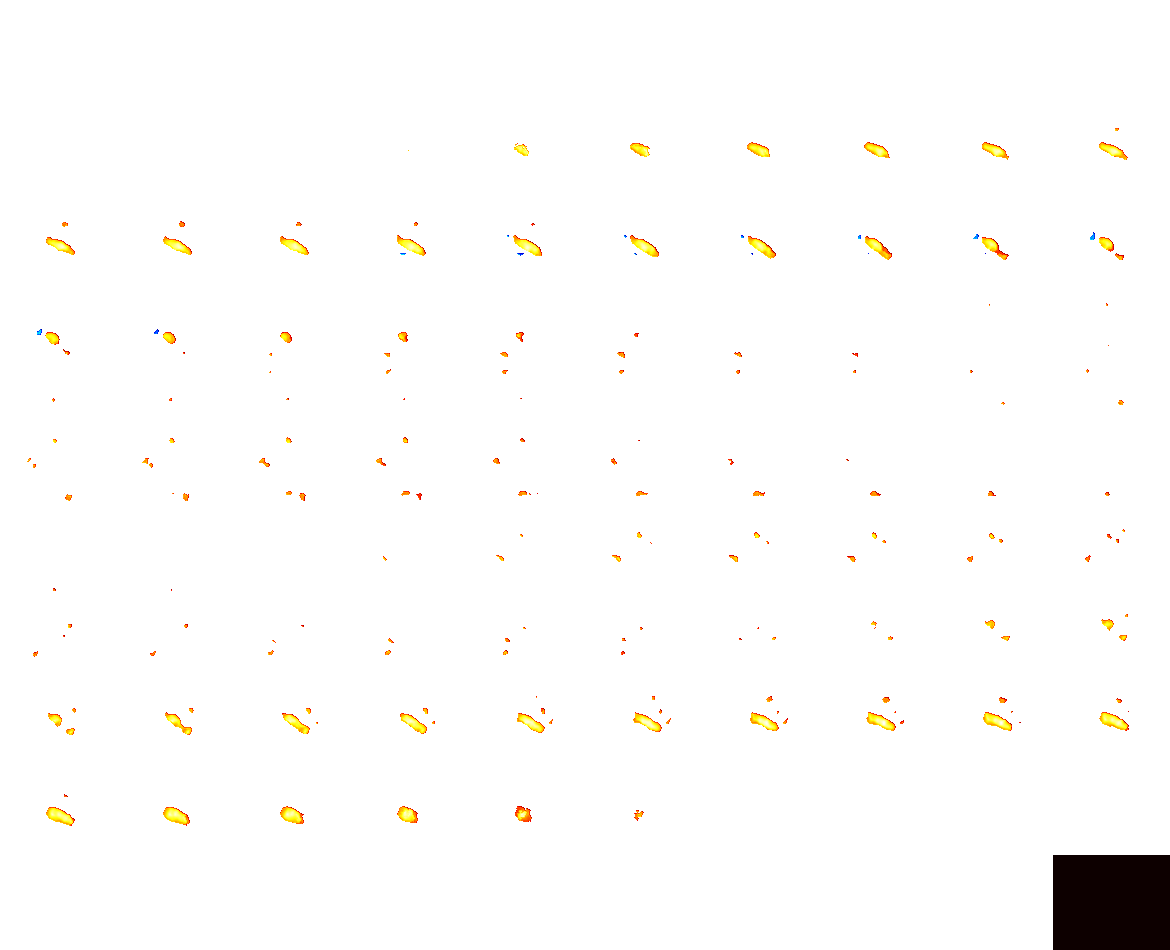

In [10]:
# View map interactively
plotting.view_img(clean_map_g,
         threshold=threshold_g
        )

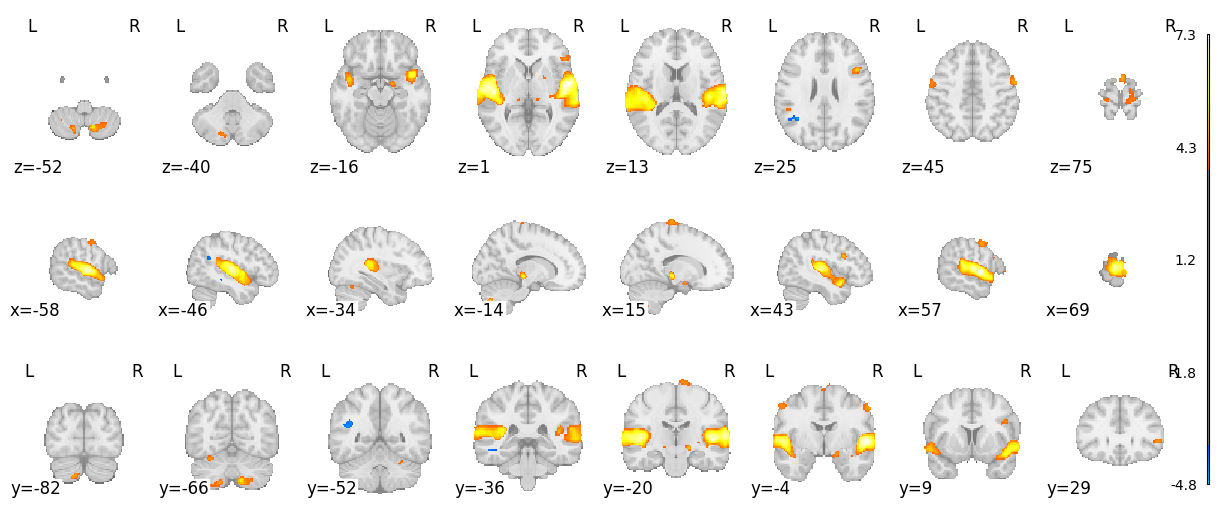

In [11]:
# create slice view of clean_map_g
plotting.plot_stat_map(
    clean_map_g,
    threshold=threshold_g,
    display_mode="mosaic",
    cut_coords=8,
    colorbar=True,
    figure=plt.figure(figsize=(12, 5)),
    symmetric_cbar=False,
    #cmap=nilearn_cmaps["cold_hot"],
)

# ROI analysis

/DATAPOOL/home/alexandresayal/anaconda3/envs/brainplayback/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



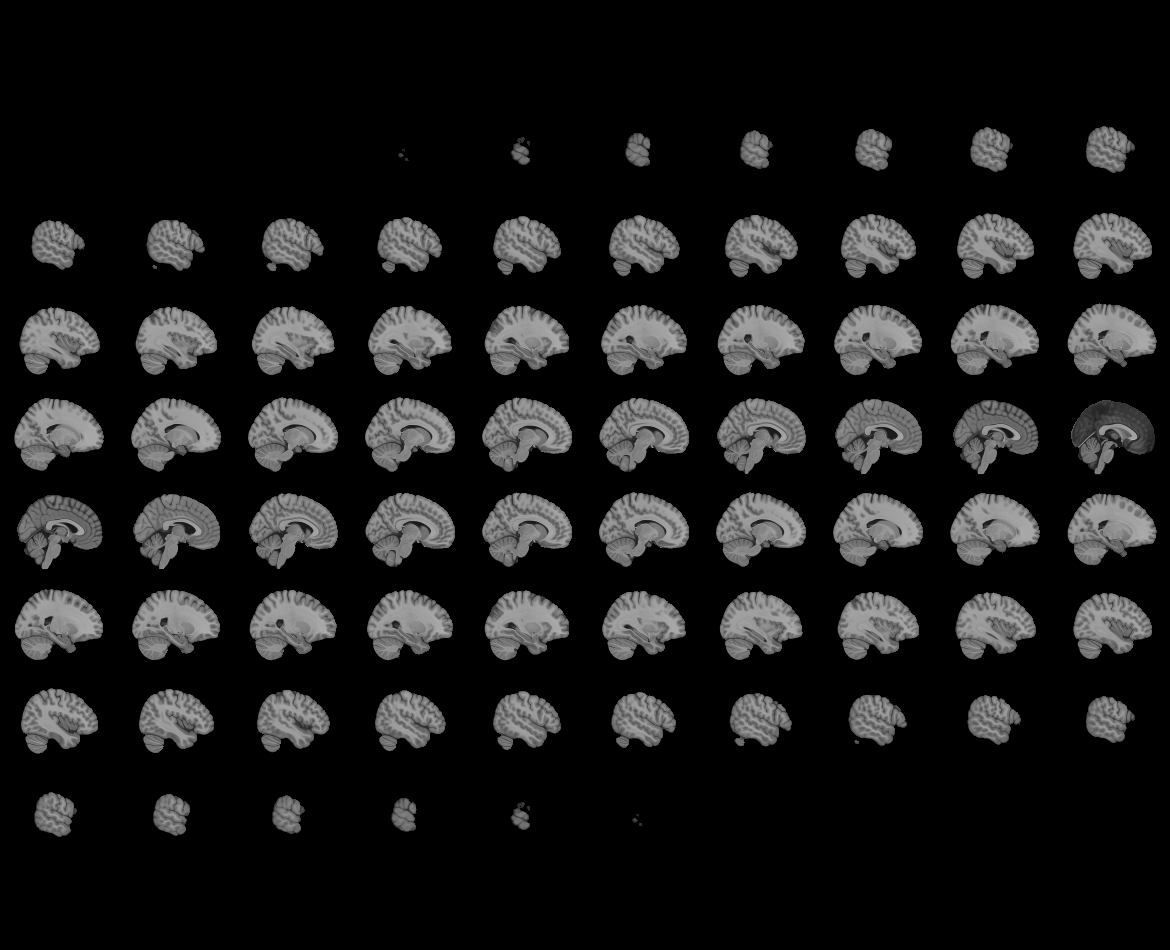
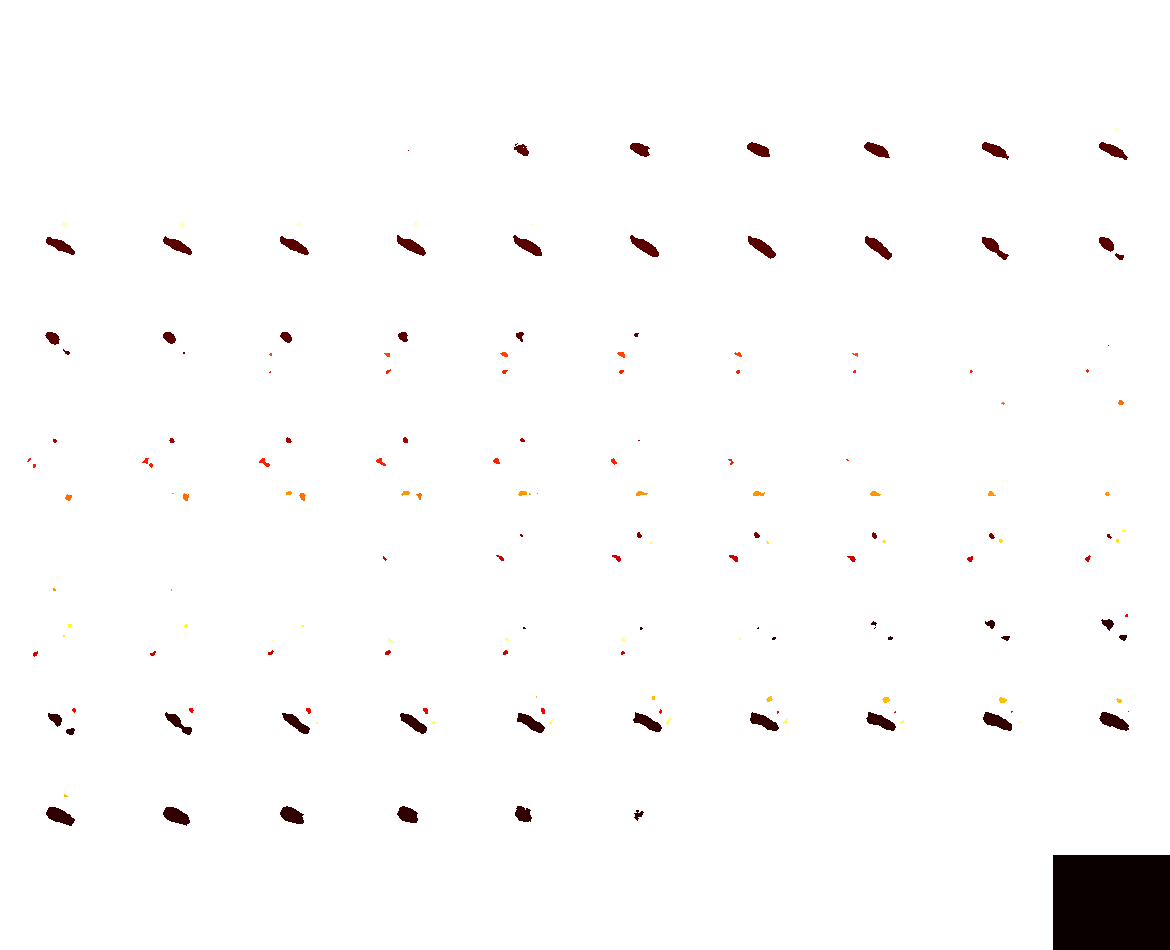

In [14]:
#| label: loc_group_interactive
# Show cluster_map_g
plotting.view_img(cluster_map_g[0],
                  #vmax=3, vmin=0,
                  resampling_interpolation='nearest',
                  cmap='hot',
                  symmetric_cmap=False)

In [15]:
# find unique values in cluster_map_g[0]
np.unique(cluster_map_g[0].get_fdata())

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17.])

/DATAPOOL/home/alexandresayal/anaconda3/envs/brainplayback/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/DATAPOOL/home/alexandresayal/anaconda3/envs/brainplayback/lib/python3.9/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(



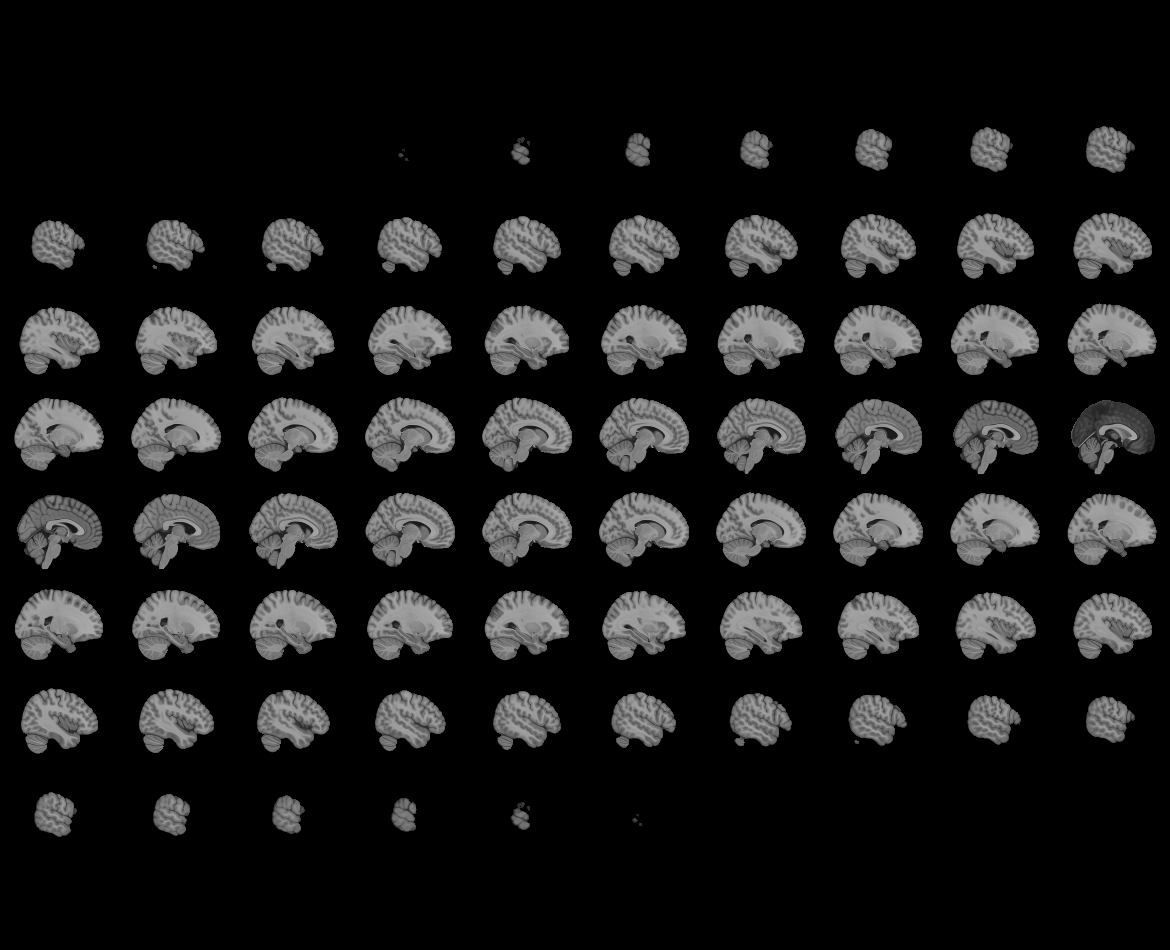
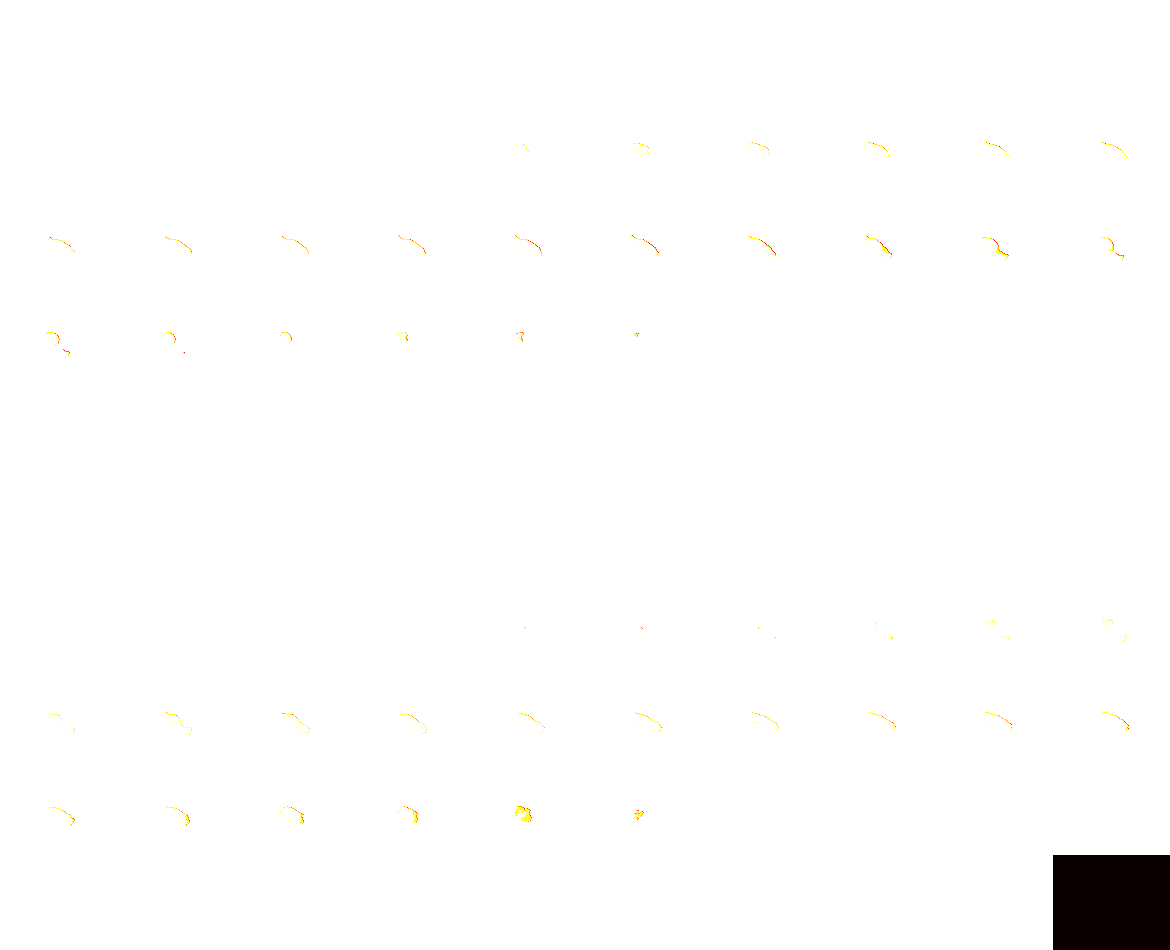

In [16]:
# Generate auditory cluster mask as an example
# in this case, it is values 1 and 2 from cluster_map_g
aux_mask1 = math_img('img == 1', img=cluster_map_g[0])
aux_mask2 = math_img('img == 2', img=cluster_map_g[0])
mask_hMT = math_img('img1 + img2', img1=aux_mask1, img2=aux_mask2)

plotting.view_img(mask_hMT, vmax=1, vmin=0, symmetric_cmap=False, cmap='hot')

# save mask
#mask_hMT.to_filename(os.path.join(data_dir,"derivatives","nilearn_glm","group",'mask_hMT.nii.gz'))


In [17]:
# fetch map values inside mask_hMT  
# Apply mask to z_map_g
z_map_hMT = apply_mask(z_map_g, mask_hMT)

# Apply mask to beta_map_g
beta_map_hMT = apply_mask(beta_map_g, mask_hMT)

# Estimate mean of z_map_hMT
z_map_hMT_mean = np.mean(z_map_hMT)

z_map_hMT_mean

5.120015024238054